# Second model presupposition - Polish Dataset

In [67]:
!pip install transformers
!pip install -q pyyaml h5py
import pandas as pd
from transformers import *
import numpy as np
from sklearn.model_selection import train_test_split


## Data Preprocessing

*   Reading data
*   Change columns names
*   Drop NaN rows
*   Fill others NaN values by special sign

In [68]:
df = pd.read_excel('polishOriginalDataset.xlsx')
df.reset_index()
df = df.iloc[:,[6,8,9,10,15,16,19,21,23]]
df.columns = [
              "type_of_sentence",
              "verb_main_semantic_class",
              "verb_second_semantic_class",
              "verb_third_semantic_class",
              "verb_veridical_positive",
              "verb_veridical_negative",
              "verb_tense",
              "t_negation",
              "presupposition"
              ]
df.dropna(inplace=True, axis = 0, how = 'all')
df.fillna(axis = 0, inplace =True, value="none")
df.head()

,type_of_sentence,verb_main_semantic_class,verb_second_semantic_class,verb_third_semantic_class,verb_veridical_positive,verb_veridical_negative,verb_tense,t_negation,presupposition
0,eliptyczne,mówienia,none,none,o?,?,brak,0,nie dotyczy
1,eliptyczne,epistemiczny,none,none,?,?,past,0,no
2,eliptyczne,mówienia,none,none,?,?,past,0,nie dotyczy
3,1,epistemiczny,percepcyjny,none,"""+""","""+""",past,0,nie dotyczy
4,1,epistemiczny,percepcyjny,none,o,o,present,0,nie dotyczy


### Cleaning data by deleting uncertainty - simplification 

In [0]:
# df.type_of_sentence.unique() cleaning not needed 
# df.verb_main_semantic_class.unique() cleaning not needed
# df.verb_second_semantic_class.unique() cleaning not needed 
# df.verb_third_semantic_class.unique() cleaning not needed

# verb veridical positive cleaning
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: '+' if '+' in x else x)
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: '-' if '-' in x else x)
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: 'o' if 'o' in x else x)
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: '?' if '?' in x else x)

# verb veridical negative cleaning
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '+' if '+' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: 'o' if 'o' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '-' if '-' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '?' if '?' in x else x)

# df.verb_tense.unique() cleaning not needed
# df.t_negation.unique() cleaning not needed
# df.semantic_relation.unique() cleaning not needed 

df = df[df["presupposition"] != "nie dotyczy"]

#### Possible feature values

In [70]:
print(df.type_of_sentence.unique())
print(df.verb_main_semantic_class.unique())
print(df.verb_second_semantic_class.unique())
print(df.verb_third_semantic_class.unique())
print(df.verb_veridical_positive.unique())
print(df.verb_veridical_negative.unique())
print(df.verb_tense.unique())
print(df.t_negation.unique())


['eliptyczne' 1 'modalne' 'powinnościowe' 'none' '?' 'warunkowe; pytajne'
 'performatyw' 'imperatyw' 'pytajne' 'wolitywne' 'warunkowe; modalne'
 'generalne' 'modalne; pytajne' 'imperatyw ' 'warunkowe']
['epistemiczny' 'percepcyjny' 'emotywny' '?' 'zdarzeniowy' 'mówienia'
 'czynnościowy' 'przyczynowy' 'dowodzenia' 'odkrycia' 'pamięciowy'
 'wnioskowania']
['none' 'percepcyjny' 'epistemiczny' 'emotywny' 'wolicjonalny'
 'wnioskowania' 'pamięciowy' 'zdarzeniowy' 'mówienia']
['none' 'mówienia' 'epistemiczny' 'percepcyjny']
['?' 'o' '+' '-']
['?' 'o' '+' '-']
['past' 'brak' 'present' 'future']
[0 1]


In [0]:
df = df[["verb_veridical_positive",
         "verb_veridical_negative",
         "verb_tense",
         "presupposition"]]
df.to_csv("plDataPresup.csv", index=False)

In [72]:
df.columns

Index(['verb_veridical_positive', 'verb_veridical_negative', 'verb_tense',
       'presupposition'],
      dtype='object')

### vectorize data and split to features and target

In [73]:
df = pd.get_dummies(df)

X_train = df.iloc[:,0:-2]
y_train = df.iloc[:,-2:]

X_train.head()

,verb_veridical_positive_+,verb_veridical_positive_-,verb_veridical_positive_?,verb_veridical_positive_o,verb_veridical_negative_+,verb_veridical_negative_-,verb_veridical_negative_?,verb_veridical_negative_o,verb_tense_brak,verb_tense_future,verb_tense_past,verb_tense_present
1,0,0,1,0,0,0,1,0,0,0,1,0
6,0,0,0,1,0,0,0,1,0,0,1,0
19,0,0,0,1,0,0,0,1,0,0,1,0
20,1,0,0,0,1,0,0,0,0,0,1,0
35,0,0,0,1,1,0,0,0,1,0,0,0


In [0]:
y_train.head()

,presupposition_no,presupposition_yes
1,1,0
6,0,1
19,0,1
20,0,1
35,0,1


***
# Keras model building

In [0]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [75]:
model = tf.keras.Sequential()

#get number of columns in training data
n_cols = X_train.shape[1]
print("Model input size {}".format(n_cols))
#add model layers
model.add(Dense(8, activation='relu', input_shape=(n_cols,)))
#model.add(Dropout(rate=0.3))
model.add(Dense(16, activation='relu'))
#model.add(Dropout(rate=0.3))
model.add(Dense(8, activation='relu'))
#model.add(Dropout(rate=0.3))
model.add(Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics = ['accuracy'])
model.summary()

Model input size 12
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_57 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 18        
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


## Training model on prepared data

In [76]:
#train model
history = model.fit(X_train, y_train, validation_split=0.4, epochs=60)

Epoch 1/60
15/15 [==============================] - 0s 10ms/step - loss: 0.6616 - accuracy: 0.6667 - val_loss: 0.6450 - val_accuracy: 0.5523
Epoch 2/60
15/15 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.7320 - val_loss: 0.6079 - val_accuracy: 0.8399
Epoch 3/60
15/15 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.7865 - val_loss: 0.5812 - val_accuracy: 0.8399
Epoch 4/60
15/15 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.7821 - val_loss: 0.5565 - val_accuracy: 0.8399
Epoch 5/60
15/15 [==============================] - 0s 4ms/step - loss: 0.5837 - accuracy: 0.7843 - val_loss: 0.5274 - val_accuracy: 0.8431
Epoch 6/60
15/15 [==============================] - 0s 4ms/step - loss: 0.5655 - accuracy: 0.7887 - val_loss: 0.5007 - val_accuracy: 0.8431
Epoch 7/60
15/15 [==============================] - 0s 4ms/step - loss: 0.5454 - accuracy: 0.7887 - val_loss: 0.4618 - val_accuracy: 0.8431
Epoch 8/60
15/15 [=

## plot with train and test accuracy

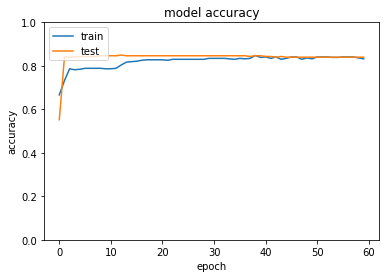

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

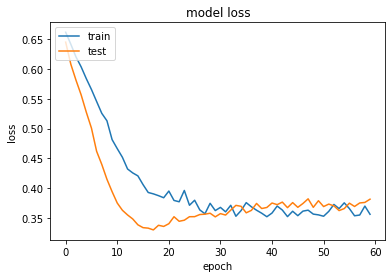

In [78]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save model 


In [0]:
model.save('featureModelPlPresup.h5')